## Import Libraries

In [3]:
import numpy as np
np.random.seed(1337)
import pandas as pd
import keras
from keras.models import Sequential
from keras import initializers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from sklearn.model_selection import train_test_split
import cv2
import os
import random
from glob import glob
import seaborn as sns
from sklearn.utils import class_weight
from keras import regularizers

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Exploration

In [4]:
# ../input/
PATH = os.path.abspath(os.path.join('input'))

# ../input/sample/images/
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")

# ../input/sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

# Load labels
labels = pd.read_csv('input/sample_labels.csv')

In [5]:
labels.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   
3                2992                 2991                        0.143   
4                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y  
0                        0.139  
1                        0.168  
2                        0.168  
3                        0.143  
4                        0.168

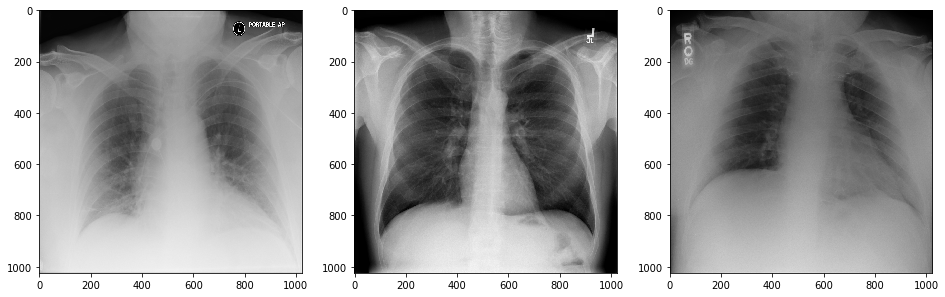

In [37]:
r = random.sample(images, 3)

plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

plt.subplot(132)
plt.imshow(cv2.imread(r[1]))

plt.subplot(133)
plt.imshow(cv2.imread(r[2]))

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
5541  00030209_008.png   Infiltration            8       30209        010Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
5541              M            AP                3056                 2544   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
5541                        0.139                        0.139

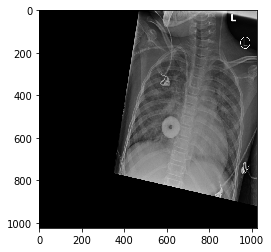

In [39]:
e = cv2.imread(os.path.join(SOURCE_IMAGES,'00030209_008.png'))

plt.imshow(e)

labels[labels["Image Index"] == '00030209_008.png']

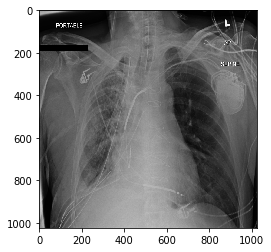

In [49]:
disease=['Hernia', 'Pneumonia', 'Fibrosis', 'Edema', 'Emphysema', 'Cardiomegaly', 'Pleural_Thickening',
        'Consolidation', 'Pneumothorax', 'Mass', 'Nodule', 'Atelectasis', 'Effusion', 'Infiltration',
        'No Finding']

e = cv2.imread(os.path.join(SOURCE_IMAGES,'00000013_005.png'))

plt.imshow(e)

label = labels[labels["Image Index"] == '00000013_005.png']
# label
# base = os.path.basename(img)
# finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
# result = finding.split('|')

        
    

### Data Cleaning & Image Resizing

In [66]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Effusion="Effusion" #4
    NoduleMass="Nodule" #5
    Atelectasis="Atelectasis"  #6 
    RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"] #7

    x = [] # images as arrays
    y = [] # labels disease
    WIDTH = 128
    HEIGHT = 128

    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        symbol = '|'
        if symbol in finding:
            continue    
        # Labels
        else:
            if NoFinding in finding:
                finding = 0
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Consolidation in finding:
                finding = 1 
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Infiltration in finding:
                finding = 2
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumothorax in finding:
                finding = 3
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Effusion in finding:
                finding = 4
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif NoduleMass in finding:
                finding = 5
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Atelectasis in finding:
                finding = 6
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif finding in RareClass:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            else:
                continue
    return x,y

def bin_proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels disease
    WIDTH = 128
    HEIGHT = 128

    for img in images:
        base = os.path.basename(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        symbol = '|'
        if symbol in finding:
            continue    
        # Labels
        else:
            if NoFinding in finding:
                finding = 0
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif NoFinding not in finding:
                finding = 1 
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            else:
                continue
    return x,y

In [88]:
x_vals, y_vals = proc_images()
bin_x_vals, bin_y_vals = bin_proc_images()

In [80]:
np.savez("x_images_arrays", x_vals)
np.savez("y_disease_labels", y_vals)
np.savez("x_images_arrays_bin", x_vals)
np.savez("y_disease_labels_bin", y_vals)

## Train, Test, Split

### Load Data

In [335]:
# Load npz file containing image arrays
x_npz = np.load("x_images_arrays.npz")
x = x_npz['arr_0']
# Load disease labels
y_npz = np.load("y_disease_labels.npz")
y = y_npz['arr_0']

In [470]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3)

In [471]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3168, 128, 128, 3)
(1359, 128, 128, 3)
(3168,)
(1359,)


In [472]:
#one-hot encode y_train & y_test
y_train = keras.utils.to_categorical(y_train, 8)
y_test = keras.utils.to_categorical(y_test, 8)

In [473]:
y_train.shape

(3168, 8)

## Processing for MLP

In [476]:
X_train_reshape = X_train.reshape(X_train.shape[0], -1).astype('float32')
X_test_reshape = X_test.reshape(X_test.shape[0], -1).astype('float32')

In [477]:
print(X_train_reshape.shape)
print(X_test_reshape.shape)

(3168, 49152)
(1359, 49152)


In [478]:
X_train_reshape /= 255
X_test_reshape /= 255

In [479]:
print(X_train_reshape.shape[0], 'train samples')
print(X_test_reshape.shape[0], 'test samples')

3168 train samples
1359 test samples


### Data Augmentation

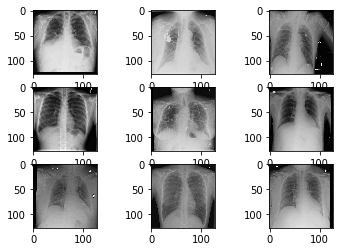

In [107]:
#Look at the first 9 images from the dataset
images = range(0,9)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

#### Randomly rotate images

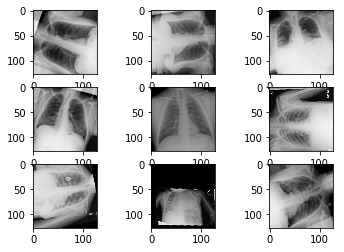

In [118]:
# Rotate images by 90 degrees
datagen = ImageDataGenerator(rotation_range=90)

# fit parameters from data
datagen.fit(X_train)

# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_minority, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(128, 128, 3))
    # show the plot
    plt.show()
    break

#### Flip Images Vertically

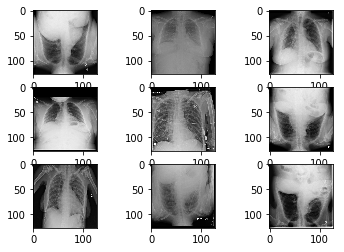

In [119]:
# Rotate images by 90 degrees
datagen = ImageDataGenerator(vertical_flip=True)

# fit parameters from data
datagen.fit(x_minority)

# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_minority, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(128, 128, 3))
    # show the plot
    plt.show()
    break

#### Shift Images Vertically or Horizontally by 20%

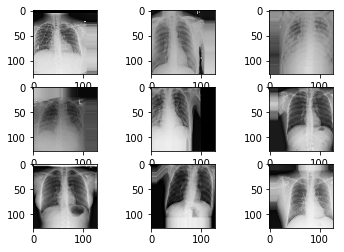

In [120]:
# Shift images vertically or horizontally 
# Fill missing pixels with the color of the nearest pixel
datagen = ImageDataGenerator(width_shift_range=.2, 
                             height_shift_range=.2,
                             fill_mode='nearest')

# fit parameters from data
datagen.fit(x_minority)

# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_minority, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(128, 128, 3))
    # show the plot
    plt.show()
    break

## Balancing class weights

In [480]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.1858984888304862,
 1: 7.859375,
 2: 1.125,
 3: 4.963815789473684,
 4: 2.7875615763546797,
 5: 3.9296875,
 6: 2.947265625,
 7: 2.2191176470588236}

### Hyperparameter Log

In [388]:
#Attempt 1
epochs=5
optimizer = optimizers.Adam(lr=0.03, decay=0.0001)
# optimizer= adam
batch_size=100
loss='categorical_crossentropy'
activation='relu'
out_activation='softmax'

### MLP

### Attempt 1 

In [389]:
model = Sequential()
model.add(Dense(50, input_dim=49152, activation=activation, kernel_initializer='he_normal'))
model.add(Dense(8, activation=out_activation))

In [390]:
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 50)                2457650   
_________________________________________________________________
dense_98 (Dense)             (None, 8)                 408       
Total params: 2,458,058
Trainable params: 2,458,058
Non-trainable params: 0
_________________________________________________________________


In [391]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 

In [392]:
history = model.fit(X_train_reshape, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_reshape, y_test))

Train on 3621 samples, validate on 906 samples
Epoch 1/5
3621/3621 [==============================] - 31s 9ms/step - loss: 5.1586 - acc: 0.6567 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 2/5
3621/3621 [==============================] - 29s 8ms/step - loss: 5.2392 - acc: 0.6750 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 3/5
3621/3621 [==============================] - 30s 8ms/step - loss: 5.2392 - acc: 0.6750 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 4/5
3621/3621 [==============================] - 33s 9ms/step - loss: 5.2392 - acc: 0.6750 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 5/5
3621/3621 [==============================] - 34s 9ms/step - loss: 5.2392 - acc: 0.6750 - val_loss: 5.4439 - val_acc: 0.6623


### Attempt 2 with L2 Regularization

In [357]:
model = Sequential()
model.add(Dense(50, input_dim=49152,  kernel_regularizer=regularizers.l2(0.005), activation=activation))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_train_reshape, y_train, epochs=epochs, batch_size=batch_size, class_weight = class_weights, verbose=1, validation_data=(X_test_reshape, y_test))

Train on 3621 samples, validate on 906 samples
Epoch 1/5
3621/3621 [==============================] - 51s 14ms/step - loss: 53.7964 - acc: 0.5742 - val_loss: 5.4483 - val_acc: 0.6623
Epoch 2/5
3621/3621 [==============================] - 56s 15ms/step - loss: 83.7706 - acc: 0.3853 - val_loss: 30.4513 - val_acc: 0.1170
Epoch 3/5
3621/3621 [==============================] - 58s 16ms/step - loss: 17.2832 - acc: 0.4239 - val_loss: 17.1183 - val_acc: 0.6623
Epoch 4/5
3621/3621 [==============================] - 56s 15ms/step - loss: 17.6624 - acc: 0.6678 - val_loss: 6.3082 - val_acc: 0.6623
Epoch 5/5
3621/3621 [==============================] - 52s 14ms/step - loss: 87.1941 - acc: 0.4328 - val_loss: 61.7453 - val_acc: 0.6623


## Attempt 3 with L1 Regularization

In [358]:
model = Sequential()
model.add(Dense(50, input_dim=49152,  kernel_regularizer=regularizers.l1(0.005), activation=activation))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_train_reshape, y_train, epochs=epochs, batch_size=batch_size, class_weight = class_weights, verbose=1, validation_data=(X_test_reshape, y_test))

Train on 3621 samples, validate on 906 samples
Epoch 1/5
3621/3621 [==============================] - 55s 15ms/step - loss: 280.0755 - acc: 0.5579 - val_loss: 100.6245 - val_acc: 0.6623
Epoch 2/5
3621/3621 [==============================] - 49s 14ms/step - loss: 148.5507 - acc: 0.5965 - val_loss: 234.8865 - val_acc: 0.6623
Epoch 3/5
3621/3621 [==============================] - 52s 14ms/step - loss: 117.3532 - acc: 0.5880 - val_loss: 82.5513 - val_acc: 0.6623
Epoch 4/5
3621/3621 [==============================] - 52s 14ms/step - loss: 91.4493 - acc: 0.6647 - val_loss: 125.6002 - val_acc: 0.6623
Epoch 5/5
3621/3621 [==============================] - 52s 14ms/step - loss: 106.2678 - acc: 0.6750 - val_loss: 52.0605 - val_acc: 0.6623


### Attempt 4 with Dropout

In [361]:
model = Sequential()
model.add(Dense(50, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_train_reshape, y_train, epochs=epochs, batch_size=batch_size, class_weight = class_weights, verbose=1, validation_data=(X_test_reshape, y_test))

Train on 3621 samples, validate on 906 samples
Epoch 1/5
3621/3621 [==============================] - 52s 14ms/step - loss: 13.9430 - acc: 0.6631 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 2/5
3621/3621 [==============================] - 47s 13ms/step - loss: 14.0018 - acc: 0.6747 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 3/5
3621/3621 [==============================] - 47s 13ms/step - loss: 14.0068 - acc: 0.6744 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 4/5
3621/3621 [==============================] - 49s 13ms/step - loss: 14.0126 - acc: 0.6738 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 5/5
3621/3621 [==============================] - 51s 14ms/step - loss: 14.0143 - acc: 0.6733 - val_loss: 5.4439 - val_acc: 0.6623


### Attempt 5 with More Neurons and Layers

In [362]:
model = Sequential()
model.add(Dense(100, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(50, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_train_reshape, y_train, epochs=epochs, batch_size=batch_size, class_weight = class_weights, verbose=1, validation_data=(X_test_reshape, y_test))

Train on 3621 samples, validate on 906 samples
Epoch 1/5
3621/3621 [==============================] - 84s 23ms/step - loss: 13.8162 - acc: 0.3764 - val_loss: 13.1827 - val_acc: 0.1821
Epoch 2/5
3621/3621 [==============================] - 75s 21ms/step - loss: 14.0464 - acc: 0.3775 - val_loss: 13.1827 - val_acc: 0.1821
Epoch 3/5
3621/3621 [==============================] - 73s 20ms/step - loss: 13.9282 - acc: 0.3971 - val_loss: 13.1827 - val_acc: 0.1821
Epoch 4/5
3621/3621 [==============================] - 72s 20ms/step - loss: 13.9877 - acc: 0.3853 - val_loss: 13.1827 - val_acc: 0.1821
Epoch 5/5
3621/3621 [==============================] - 73s 20ms/step - loss: 13.9530 - acc: 0.3935 - val_loss: 13.1827 - val_acc: 0.1821


### Attempt 6 with More Neurons, only 1 Layer


In [363]:
model = Sequential()
model.add(Dense(100, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_train_reshape, y_train, epochs=epochs, batch_size=batch_size, class_weight = class_weights, verbose=1, validation_data=(X_test_reshape, y_test))

Train on 3621 samples, validate on 906 samples
Epoch 1/5
3621/3621 [==============================] - 75s 21ms/step - loss: 13.9429 - acc: 0.6669 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 2/5
3621/3621 [==============================] - 71s 20ms/step - loss: 14.0135 - acc: 0.6750 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 3/5
3621/3621 [==============================] - 74s 20ms/step - loss: 14.0135 - acc: 0.6750 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 4/5
3621/3621 [==============================] - 74s 20ms/step - loss: 14.0135 - acc: 0.6750 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 5/5
3621/3621 [==============================] - 76s 21ms/step - loss: 14.0135 - acc: 0.6750 - val_loss: 5.4439 - val_acc: 0.6623


## Attempt 7 with More Neurons

In [401]:
model = Sequential()
model.add(Dense(100, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_train_reshape, y_train, epochs=epochs, batch_size=batch_size, class_weight = class_weights, verbose=1, validation_data=(X_test_reshape, y_test))

Train on 3621 samples, validate on 906 samples
Epoch 1/5
3621/3621 [==============================] - 56s 16ms/step - loss: 13.7023 - acc: 0.6413 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 2/5
3621/3621 [==============================] - 52s 14ms/step - loss: 14.0242 - acc: 0.6700 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 3/5
3621/3621 [==============================] - 54s 15ms/step - loss: 14.0175 - acc: 0.6694 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 4/5
3621/3621 [==============================] - 59s 16ms/step - loss: 14.0266 - acc: 0.6664 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 5/5
3621/3621 [==============================] - 59s 16ms/step - loss: 14.0067 - acc: 0.6686 - val_loss: 5.4439 - val_acc: 0.6623


### More Complexity

In [405]:
tbcallback = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, 
                                         write_graph=True, write_images=True)

In [403]:
model = Sequential()
model.add(Dense(100, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_train_reshape, y_train, epochs=10, batch_size=batch_size, class_weight = class_weights, verbose=1, validation_data=(X_test_reshape, y_test), callbacks=[tbcallback])

Train on 3621 samples, validate on 906 samples


KeyboardInterrupt: 

### Even More Complexity - Best One So Far

In [488]:
model = Sequential()
model.add(Dense(100, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(10, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_train_reshape, y_train, epochs=10, batch_size=batch_size, class_weight = class_weights, verbose=1, validation_data=(X_test_reshape, y_test), callbacks=[tbcallback])

Train on 3168 samples, validate on 1359 samples
Epoch 1/10
2500/3168 [======================>.......] - ETA: 9s - loss: 12.8042 - acc: 0.1644 

KeyboardInterrupt: 

In [411]:
results_train = model.evaluate(X_train_reshape, y_train)
results_train

3621/3621 [==============================] - 23s 6ms/step


[5.23916002756586, 0.6749516708173992]

In [412]:
results_test = model.evaluate(X_test_reshape, y_test)
results_test

906/906 [==============================] - 6s 6ms/step


[5.4438600350689414, 0.6622516556291391]

In [413]:
val_dict = history.history

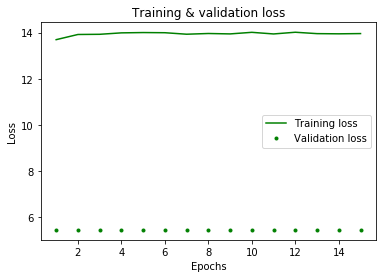

In [414]:
plt.clf()

import matplotlib.pyplot as plt
loss_values = val_dict['loss']
val_loss_values = val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

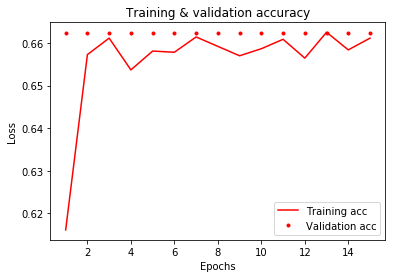

In [415]:
plt.clf()

acc_values = val_dict['acc'] 
val_acc_values = val_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [422]:
model = Sequential()
model.add(Dense(100, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(10, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_train_reshape, y_train, epochs=20, batch_size=batch_size, class_weight = class_weights, verbose=1, validation_data=(X_test_reshape, y_test), callbacks=[tbcallback])

Train on 3621 samples, validate on 906 samples
Epoch 1/20
3621/3621 [==============================] - 54s 15ms/step - loss: 12.1076 - acc: 0.5650 - val_loss: 5.4439 - val_acc: 0.6623
Epoch 2/20
3621/3621 [==============================] - 54s 15ms/step - loss: 12.4898 - acc: 0.5766 - val_loss: 15.2820 - val_acc: 0.0519
Epoch 3/20
3621/3621 [==============================] - 55s 15ms/step - loss: 11.0158 - acc: 0.0917 - val_loss: 15.2820 - val_acc: 0.0519
Epoch 4/20
3621/3621 [==============================] - 58s 16ms/step - loss: 11.2274 - acc: 0.0817 - val_loss: 15.2820 - val_acc: 0.0519
Epoch 5/20
3621/3621 [==============================] - 59s 16ms/step - loss: 10.6776 - acc: 0.1074 - val_loss: 15.2820 - val_acc: 0.0519
Epoch 6/20
3621/3621 [==============================] - 56s 16ms/step - loss: 10.7207 - acc: 0.0884 - val_loss: 15.2820 - val_acc: 0.0519
Epoch 7/20
3621/3621 [==============================] - 64s 18ms/step - loss: 10.8686 - acc: 0.0991 - val_loss: 15.2820 - val_

KeyboardInterrupt: 

## Random Oversampling

In [446]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, y_trainRos = ros.fit_sample(X_train_reshape, y_train)
X_testRos, y_testRos = ros.fit_sample(X_test_reshape, y_test)

y_trainRosHot = keras.utils.to_categorical(y_trainRos, num_classes = 8)
y_testRosHot = keras.utils.to_categorical(y_testRos, num_classes = 8)


In [448]:
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_train_reshape.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)
print("Y_trainRosHot Shape: ",y_trainRosHot.shape)
print("Y_testRosHot Shape: ",y_testRosHot.shape)

X_train:  (3621, 128, 128, 3)
X_trainFlat:  (3621, 49152)
X_trainRos Shape:  (19552, 49152)
X_testRos Shape:  (4800, 49152)
Y_trainRosHot Shape:  (19552, 8)
Y_testRosHot Shape:  (4800, 8)


In [ ]:
#reshape for CNNs
for i in range(len(X_trainRos)):
    height, width, channels = 128,128,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 128,128,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
print("X_testRos Shape: ",X_testRos.shape)
print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

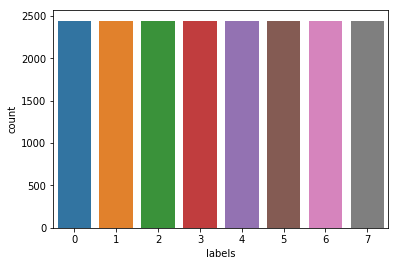

In [455]:
dfRos = pd.DataFrame()
dfRos["labels"]=y_trainRos
labRos = dfRos['labels']
lab = df['labels']
distRos = lab.value_counts()
sns.countplot(labRos)

In [456]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_trainRos), y_trainRos)
print("New Class Weights: ",class_weight)

New Class Weights:  [1. 1. 1. 1. 1. 1. 1. 1.]


In [469]:
model = Sequential()
model.add(Dense(100, input_dim=49152, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(25, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(75, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(10, activation=activation))
model.add(Dropout(0.3))
model.add(Dense(8, activation=out_activation))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
history = model.fit(X_trainRos, y_trainRosHot, epochs=5, batch_size=batch_size, verbose=1, validation_data=(X_testRos, y_testRosHot), callbacks=[tbcallback])

Train on 19552 samples, validate on 4800 samples
Epoch 1/5
19552/19552 [==============================] - 365s 19ms/step - loss: 11.6057 - acc: 0.1297 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 2/5
19552/19552 [==============================] - 365s 19ms/step - loss: 12.1417 - acc: 0.1240 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 3/5
11600/19552 [================>.............] - ETA: 1:58 - loss: 12.4756 - acc: 0.1262

KeyboardInterrupt: 